# Percolation
Simulation to demonstrate largest cluster size and average cluster size in site percolation model.

References:
- [1] Percolation Theory, Kim Christensen
- [2] P. H. A. M. Deckmyn, G. A. Davies, and D. J. Bell, “Properties of percolating clusters on finite lattices applied to model filtration processes,” Applied Mathematical Modelling, vol. 19, no. 5, pp. 258–269, May 1995, doi: 10.1016/0307-904X(94)00032-2.
- [3] D. Stauffer, “Scaling theory of percolation clusters,” Physics Reports, vol. 54, no. 1, pp. 1–74, Jul. 1979, doi: 10.1016/0370-1573(79)90060-7.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as nd_sum
import json

# Plot setting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'  # Use the Computer Modern Roman font
plt.rcParams['mathtext.fontset'] = 'cm'  # Use Computer Modern for math text
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.labelsize'] = 16  # Axis labels
plt.rcParams['axes.titlesize'] = 20  # Title
plt.rcParams['xtick.labelsize'] = 14 # X tick labels
plt.rcParams['ytick.labelsize'] = 14 # Y tick labels

MAINREDS = ['#fac9c7','#ea9a9d', '#d95e5b', '#c23737', '#922421','#6a1815']
MAINBLUES = ['#c1e4fa', '#93c4ea' ,'#4c90cb', '#0169a9', '#004586', '#002752']
MAINYELLOWS = ['#ffefbb','#ffefbb','#e8c147', '#c59527', '#926d18', '#604b14']

In [ ]:
def simulate_percolation(N, p):
    """Generate a percolated lattice based on occupation probability `p`."""
    lattice = np.random.rand(N, N) < p
    return lattice

def identify_percolating_cluster(labeled_clusters, N):
    """Identify if a cluster spans from one side to the opposite side of the lattice."""
    top = labeled_clusters[0, :]
    bottom = labeled_clusters[N - 1, :]
    left = labeled_clusters[:, 0]
    right = labeled_clusters[:, N - 1]
    
    percolating_labels = np.union1d(np.intersect1d(top, bottom), np.intersect1d(left, right))
    return percolating_labels[percolating_labels != 0]

def compute_cluster_sizes_excluding_percolating(lattice):
    """Identify and compute cluster sizes excluding percolating clusters."""
    labeled_clusters, num = label(lattice)
    cluster_sizes = nd_sum(lattice, labeled_clusters, index=np.arange(1, num + 1))
    
    if len(cluster_sizes) ==0:
        return np.array([])
    
    # Identify the percolating clusters
    percolating_clusters = identify_percolating_cluster(labeled_clusters, lattice.shape[0])
    
    # Exclude the percolating clusters
    finite_clusters = np.array([size for idx, size in enumerate(cluster_sizes, start=1) 
                                if idx not in percolating_clusters])
    unique_sizes, counts = np.unique(finite_clusters, return_counts=True)
    ws = unique_sizes * counts / np.dot(unique_sizes, counts)
    size_distribution = np.column_stack((unique_sizes, counts, ws))
    return size_distribution

def compute_cluster_size_max(lattice):
    """Identify max cluster."""
    labeled_clusters, num = label(lattice)
    cluster_sizes = nd_sum(lattice, labeled_clusters, index=np.arange(1, num + 1))
    
    if len(cluster_sizes) == 0:
        return np.array([])
    
    return np.array([cluster_sizes.max(), 1, 1]).reshape(1,3)

def compute_cluster_sizes_excluding_max(lattice):
    """Identify and compute cluster sizes excluding max clusters."""
    labeled_clusters, num = label(lattice)
    cluster_sizes = nd_sum(lattice, labeled_clusters, index=np.arange(1, num + 1))
    
    if len(cluster_sizes) == 0:
        return np.array([])
    
    # Identify the largest clusters
    largest_cluster = cluster_sizes.max()
    
    # Exclude the largest clusters
    finite_clusters = cluster_sizes[cluster_sizes != largest_cluster]
    
    unique_sizes, counts = np.unique(finite_clusters, return_counts=True)
    ws = unique_sizes * counts / np.dot(unique_sizes, counts)
    size_distribution = np.column_stack((unique_sizes, counts, ws))
    return size_distribution

def compute_cluster_size_distribution_all_clusters(lattice):
    """Identify and compute all cluster sizes and their counts in the lattice."""
    labeled_clusters, num = label(lattice)
    cluster_sizes = nd_sum(lattice, labeled_clusters, index=np.arange(1, num + 1))
    unique_sizes, counts = np.unique(cluster_sizes, return_counts=True)
    ws = unique_sizes * counts / np.dot(unique_sizes, counts)
    size_distribution = np.column_stack((unique_sizes, counts, ws))
    return size_distribution

def mean_cluster_size(size_distribution):
    """Compute the mean cluster size excluding the largest cluster."""
    if len(size_distribution) == 0:
        return 0
    mean_size = np.dot(size_distribution[:,0],size_distribution[:,2])
    return mean_size

def mean_cluster_size_vs_p(N, p_values, num_trials=100, mode='default'):
    """Compute the average cluster size over different probabilities."""
    mean_sizes = []
    for p in p_values:
        sizes = []
        for _ in range(num_trials):
            lattice = simulate_percolation(N, p)
            if mode == 'ex_max':
                size_distribution = compute_cluster_sizes_excluding_max(lattice)
            elif mode == 'ex_none':
                size_distribution = compute_cluster_size_distribution_all_clusters(lattice)
            elif mode == 'max_only':
                size_distribution = compute_cluster_size_max(lattice)
            else:
                size_distribution = compute_cluster_sizes_excluding_percolating(lattice)
            sizes.append(mean_cluster_size(size_distribution))
        mean_sizes.append(np.mean(sizes)) #compute mean for all trials
    return mean_sizes

## Modelling

In [ ]:
%%time
# Largest cluster only (phase transition, disorder-order)
lattice_sizes = [50, 100, 200]
p_values = np.linspace(0.1, 0.9, 101)
num_trials = 10000
results_lcs = {}

for L in lattice_sizes:
    max_sizes = mean_cluster_size_vs_p(L, p_values, num_trials=num_trials, mode='max_only')
    results_lcs[L] = max_sizes

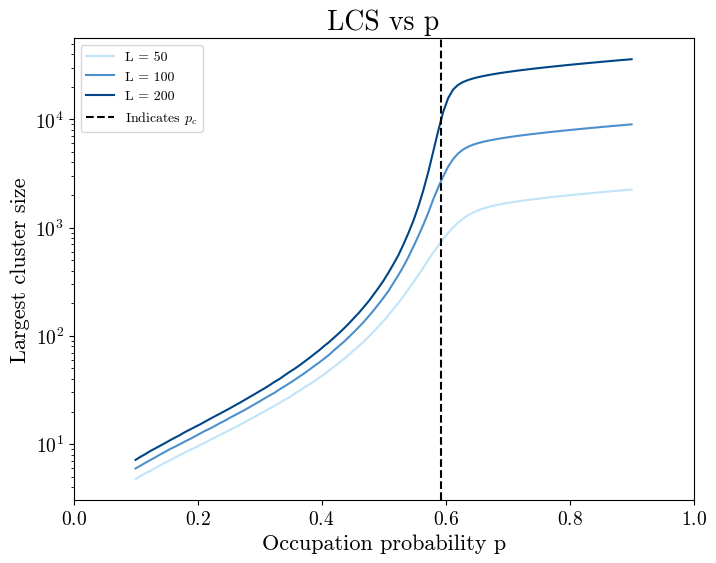

In [7]:
# plot LCS
plt.figure(figsize=(8, 6)) 
col_id = 0
for lattice_size, lcs in results_lcs.items():
    plt.plot(p_values, lcs, label=f'L = {lattice_size}', color=MAINBLUES[col_id])
    col_id += 2
plt.axvline(x=0.5927, color='k', linestyle='--', label='Indicates $p_c$')
plt.xlabel('Occupation probability p')
plt.ylabel('Largest cluster size')
plt.yscale('log');
plt.xlim((0,1));
plt.title('LCS vs p');
plt.legend();
plt.savefig('perco_LCS.png', dpi=300);

In [ ]:
%%time
# ACS Exclude percolating cluster
lattice_sizes = [50, 100, 200]
p_values = np.linspace(0.1, 0.9, 101)
num_trials = 10000
results_acs = {}

for N in lattice_sizes:
    mean_sizes = mean_cluster_size_vs_p(N, p_values, num_trials=num_trials)
    results_acs[N] = mean_sizes

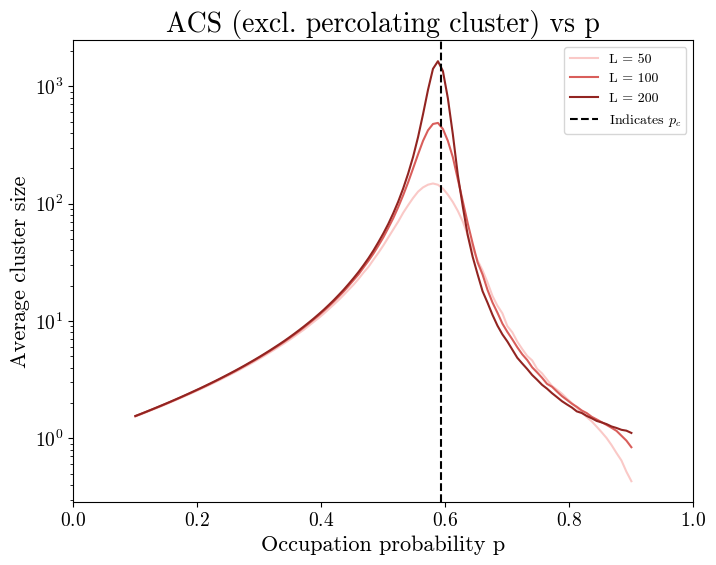

In [8]:
# plot
plt.figure(figsize=(8, 6))
col_id = 0
for lattice_size, acs in results_acs.items():
    plt.plot(p_values, acs, label=f'L = {lattice_size}', color=MAINREDS[col_id])
    col_id += 2

plt.axvline(x=0.5927, color='k', linestyle='--', label='Indicates $p_c$')
plt.xlabel('Occupation probability p')
plt.ylabel('Average cluster size')
plt.xlim((0,1))
plt.yscale('log');
plt.title('ACS (excl. percolating cluster) vs p');
plt.legend()
plt.savefig('perco_ACS.png', dpi=300);